In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '5,'
from pathlib import Path
from argparse import Namespace
from tqdm import tqdm
import json

import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from PIL import Image

import torch
torch.cuda.empty_cache()
from torchvision.utils import make_grid

from gaussian_renderer import render
from scene import GaussianModel
from scene.cameras import Camera
from scene.colmap_loader import qvec2rotmat, read_extrinsics_binary, read_intrinsics_binary
from scene.dataset_readers import fetchPly
from scene.multipleview_dataset import multipleview_dataset
from scripts.geometry import render_from_pcl, get_gaussian_coords, calculate_metrics
from utils.graphics_utils import focal2fov

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
hyper = Namespace(**{
    'net_width': 128, 'timebase_pe': 4, 'defor_depth': 0, 'posebase_pe': 10,
    'scale_rotation_pe': 2, 'opacity_pe': 2, 'timenet_width': 64, 'timenet_output': 32,
    'bounds': 1.6, 'plane_tv_weight': 0.0002, 'time_smoothness_weight': 0.001, 'l1_time_planes': 0.0001,
    'kplanes_config': {
        'grid_dimensions': 2, 
        'input_coordinate_dim': 4, 
        'output_coordinate_dim': 16, 
        'resolution': [64, 64, 64, 150]
    }, 'multires': [1, 2],
    'no_dx': False, 'no_grid': False, 'no_ds': False, 'no_dr': False, 'no_do': False, 'no_dshs': False,
    'empty_voxel': False, 'grid_pe': 0, 'static_mlp': False, 'apply_rotation': False,
})

pipe = Namespace(**{
    'convert_SHs_python': False,
    'compute_cov3D_python': False,
    'debug': False,
})

### Parallel

In [3]:
og_path = Path(f"ParallelDomain/scene_000000")
source_path = Path(f"samples/ParallelDomain/scene_000000/colmap")
model_path = Path(f"samples/ParallelDomain/scene_000000/outputs_v2")

gaussians = GaussianModel(3, hyper)

pcd = fetchPly(source_path / "points3D_multipleview.ply")
xyz_max, xyz_min = pcd.points.max(axis=0), pcd.points.min(axis=0)
gaussians._deformation.deformation_net.set_aabb(xyz_max,xyz_min)

gaussians.load_ply(model_path / f"point_cloud/coarse_iteration_3000/point_cloud.ply")
gaussians.load_model(model_path / f"point_cloud/coarse_iteration_3000")

cam_extrinsics=read_extrinsics_binary(str(source_path / "sparse/0/images.bin")) 
cam_intrinsics=read_intrinsics_binary(str(source_path / "sparse/0/cameras.bin"))

print("\n")
for k,v in cam_extrinsics.items():
    # c_id = f"{int(v.name.split('.')[0].replace('image', '')):02d}"
    c_id = v.name
    print(f"{k} ({source_path}/{c_id}) : qvec {v.qvec} tvec {v.tvec}")
    v2 = cam_intrinsics[v.camera_id]
    # print(f"\tcamera{v.camera_id} ({v2.width}, {v2.height}) : {v2.params}")


feature_dim: 32
Deformation Net Set aabb [199.213  59.477  30.264] [-128.943  -16.275   -1.758]
Voxel Plane: set aabb= Parameter containing:
tensor([[ 199.213,   59.477,   30.264],
        [-128.943,  -16.275,   -1.758]])
loading model from existssamples/ParallelDomain/scene_000000/outputs_v2/point_cloud/coarse_iteration_3000


1 (samples/ParallelDomain/scene_000000/colmap/camera12-rgba_00000.png) : qvec [ 0.     0.    -0.927  0.375] tvec [ 0.    -3.018 11.265]
2 (samples/ParallelDomain/scene_000000/colmap/camera13-rgba_00000.png) : qvec [ 0.178  0.363 -0.821  0.403] tvec [ 0.    -4.032 15.048]
3 (samples/ParallelDomain/scene_000000/colmap/camera1-rgba_00000.png) : qvec [ 0.413  0.652 -0.537  0.34 ] tvec [ 0.    -8.706 32.491]
4 (samples/ParallelDomain/scene_000000/colmap/camera11-rgba_00000.png) : qvec [ 0.178  0.363  0.821 -0.403] tvec [-0.    -4.032 15.048]
5 (samples/ParallelDomain/scene_000000/colmap/camera0-rgba_00000.png) : qvec [ 0.39  0.59 -0.59  0.39] tvec [  0.    -10.981  4

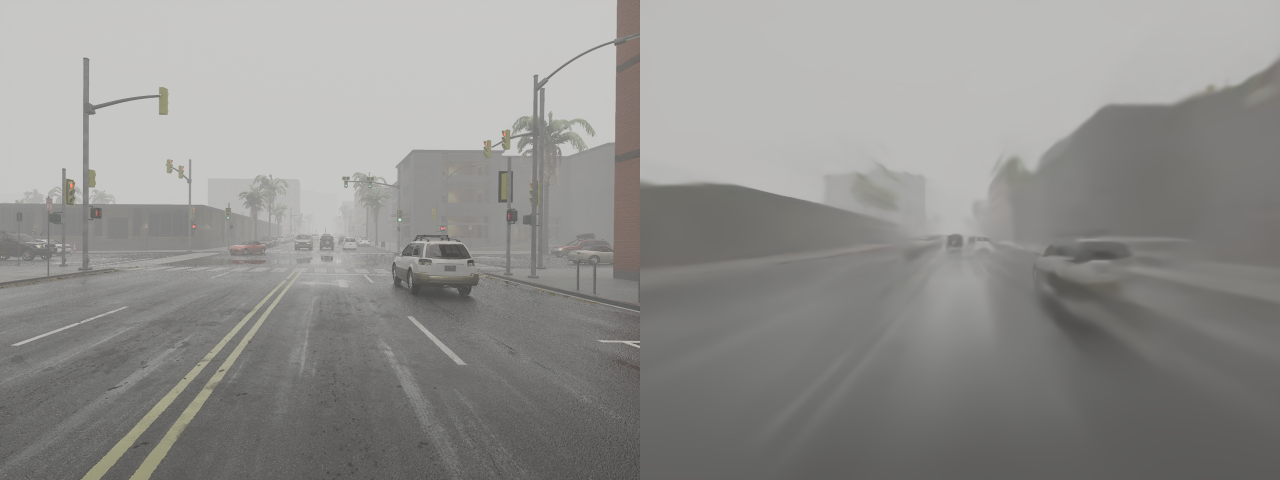

In [13]:
k = list(cam_extrinsics.keys())[15]
time = 0.0

cam_e = cam_extrinsics[k]
cam_i = cam_intrinsics[cam_e.camera_id]
focal = cam_i.params[0]
FovX = focal2fov(focal, cam_i.width)
FovY = focal2fov(focal, cam_i.height)

R, T = np.array(qvec2rotmat(cam_e.qvec)).T, np.array(cam_e.tvec)

view = Camera(
    colmap_id=0,R=R,T=T,FoVx=FovX,FoVy=FovY,
    image=torch.zeros((4,480,640)),gt_alpha_mask=None,
    image_name=f"{0}",uid=0,data_device=torch.device("cuda"),
    time=time,mask=None)
# print(view)

with torch.no_grad():
    rendering = render(view, gaussians, pipe, 
                       bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                       stage='coarse',  cam_type='Kubric')["render"]
    
# c_id = f"{int(v.name.split('.')[0].replace('image', '')):02d}"
# gt_img = np.asarray(Image.open(source_path / f"cam{c_id:02d}/frame_{time+1:05d}.jpg"))
gt_img = np.asarray(Image.open(source_path / f"images/{cam_e.name}").resize((640,480)))
res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
Image.fromarray(np.concatenate([gt_img[...,:3], res_img[...,:3]], axis=1))

In [14]:
from scripts.geometry import extrinsics_from_look_at, construct_trajectory

out_path = Path("tmp/")
out_path.mkdir(parents=True, exist_ok=True)

control_info = json.loads(Path("../gcd/eval/list/pardom_valtest_controls.json").read_bytes())
control_entry = control_info['scene_000000']['sample_01']
frame_start, frame_skip = control_entry['frame_start'], control_entry['frame_skip']
fps = int(round(10 / frame_skip))
clip_frames = np.arange(14) * frame_skip + frame_start

position_start = np.array([1.60, 0.0, 1.55], dtype=np.float32)
position_end = np.array([-8.0, 0.0, 8.0], dtype=np.float32)
(_, position_dst) = construct_trajectory(position_start, position_end, 'interpol_sine', 14, 13)
look_at_start = np.array([6.60, 0.0, 1.55], dtype=np.float32)
look_at_end = np.array([5.60, 0.0, 1.55], dtype=np.float32)
(_, look_at_dst) = construct_trajectory(look_at_start, look_at_end, 'interpol_sine', 14, 13)

images = []
for t in range(14):
    RT = extrinsics_from_look_at(position_dst[t], look_at_dst[t])
    RT = np.linalg.inv(RT)
    R, T = RT[:3,:3].T, RT[:3,3]

    view = Camera(
        colmap_id=0,R=R,T=T,FoVx=FovX,FoVy=FovY,
        image=torch.zeros((4,480,640)),gt_alpha_mask=None,
        image_name=f"{0}",uid=0,data_device=torch.device("cuda"),
        time=time,mask=None)
    # print(view)

    with torch.no_grad():
        rendering = render(view, gaussians, pipe, 
                        bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                        stage='coarse',  cam_type='Kubric')["render"]
        
    res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
    images.append(Image.fromarray(res_img[...,:3]))


### Kubric

In [ ]:
name = "scn02902"
og_path = Path(f"kubric4d/test/{name}")
# source_path = Path(f"data/multipleview/{name}")
# model_path = Path(f"output/multipleview/{name}")
source_path = Path(f"samples/{name}/colmap")
model_path = Path(f"samples/{name}/outputs_v2")

gaussians = GaussianModel(3, hyper)

pcd = fetchPly(source_path / "points3D_multipleview.ply")
xyz_max, xyz_min = pcd.points.max(axis=0), pcd.points.min(axis=0)
gaussians._deformation.deformation_net.set_aabb(xyz_max,xyz_min)

gaussians.load_ply(model_path / f"point_cloud/coarse_iteration_3000/point_cloud.ply")
gaussians.load_model(model_path / f"point_cloud/coarse_iteration_3000")

cam_extrinsics=read_extrinsics_binary(str(source_path / "sparse/0/images.bin")) 
cam_intrinsics=read_intrinsics_binary(str(source_path / "sparse/0/cameras.bin"))

print("\n")
for k,v in cam_extrinsics.items():
    # c_id = f"{int(v.name.split('.')[0].replace('image', '')):02d}"
    c_id = v.name
    print(f"{k} ({source_path}/{c_id}) : qvec {v.qvec} tvec {v.tvec}")
    v2 = cam_intrinsics[v.camera_id]
    print(f"\tcamera{v.camera_id} ({v2.width}, {v2.height}) : {v2.params}")


In [ ]:
k = list(cam_extrinsics.keys())[11]
time = 0.5

cam_e = cam_extrinsics[k]
cam_i = cam_intrinsics[cam_e.camera_id]
focal = cam_i.params[0]
FovX = focal2fov(focal, cam_i.width)
FovY = focal2fov(focal, cam_i.height)

R, T = np.array(qvec2rotmat(cam_e.qvec)).T, np.array(cam_e.tvec)

view = Camera(
    colmap_id=0,R=R,T=T,FoVx=FovX,FoVy=FovY,
    image=torch.zeros((4,384,576)),gt_alpha_mask=None,
    image_name=f"{0}",uid=0,data_device=torch.device("cuda"),
    time=time,mask=None)
# print(view)

with torch.no_grad():
    rendering = render(view, gaussians, pipe, 
                       bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                       stage='coarse',  cam_type='Kubric')["render"]
    
# c_id = f"{int(v.name.split('.')[0].replace('image', '')):02d}"
# gt_img = np.asarray(Image.open(source_path / f"cam{c_id:02d}/frame_{time+1:05d}.jpg"))
gt_img = np.asarray(Image.open(source_path / f"images/{cam_e.name}").resize((576,384)))
res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
Image.fromarray(np.concatenate([gt_img[...,:3], res_img[...,:3]], axis=1))

In [ ]:
timesteps = 14
project_size = (280, 420)
render_size = (256, 384)
FovX = 2*np.arctan(576/(2*576)).astype(np.float32)
FovY = 2*np.arctan(384/(2*576)).astype(np.float32)

controlinfo_path = Path("gcd/eval/list/kubric_valtest_controls_gradual.json")
pcl_root = Path("kubric4d/test_pcl/")
control_info = json.loads(controlinfo_path.read_bytes())

# name = "scn02970"
og_path = Path(f"kubric4d/test/{name}")
source_path = Path(f"samples/{name}/colmap")
model_path = Path(f"samples/{name}/outputs_2")

out_dir = Path(f"samples/metric_output/{name}")
(out_dir / "rgb_src").mkdir(parents=True, exist_ok=True)
(out_dir / "rgb_dst").mkdir(parents=True, exist_ok=True)
(out_dir / "reproject").mkdir(parents=True, exist_ok=True)
(out_dir / "result").mkdir(parents=True, exist_ok=True)

control_entry = control_info[name]['sample_00']
frame_start, frame_skip = control_entry['frame_start'], control_entry['frame_skip']
fps = int(round(24/frame_skip))
clip_frames = np.arange(timesteps) * frame_skip + frame_start

intrinsics = torch.tensor([[1., 0., 0.5], [0., 1.5, 0.5], [0., 0., 1.]]).to('cuda')
intrinsics[0, :] *= project_size[1]
intrinsics[1, :] *= project_size[0]

pcl_rgb_all, pcl_xyz_all = [], []
for t in clip_frames:
    (pcl_xyz, pcl_rgb, pcl_segm_rgb) = torch.load(pcl_root / f'{name}/pcl_rgb_segm_{t:05d}.pt')
    pcl_rgb_all.append(pcl_rgb / 255.)
    pcl_xyz_all.append(pcl_xyz)

with torch.no_grad():
    rgb_src = []
    rgb_dst = []
    reproject = []
    pred_samples = []
    for i, t in enumerate(clip_frames):
        time = np.array(t / 60., dtype=np.float32)
        cur_xyzrgb = torch.cat([pcl_xyz_all[i], pcl_rgb_all[i]], axis=-1).reshape(-1, 6).type(torch.float64).to('cuda')
        src_xyzrgb = torch.cat([pcl_xyz_all[i][4], pcl_rgb_all[i][4]], axis=-1).type(torch.float64).to('cuda')

        blur_synth1 = render_from_pcl(cur_xyzrgb, np.array(control_entry['spherical_src'][i]), 
            intrinsics, project_size = project_size, render_size = render_size)
        rgb_src.append(blur_synth1)

        blur_synth2 = render_from_pcl(cur_xyzrgb, np.array(control_entry['spherical_dst'][i]), 
            intrinsics, project_size = project_size, render_size = render_size)
        rgb_dst.append(blur_synth2)
        
        blur_synth3 = render_from_pcl(src_xyzrgb, np.array(control_entry['spherical_dst'][i]), 
            intrinsics, project_size = project_size, render_size = render_size)
        reproject.append(blur_synth3)

        R, T = get_gaussian_coords(np.array(control_entry['spherical_dst'][i]))
        view = Camera(
            colmap_id=0,R=R,T=T,
            FoVx=FovX,FoVy=FovY,
            image=torch.zeros((4,)+render_size),gt_alpha_mask=None,
            image_name=f"{0}",uid=0,data_device=torch.device("cuda"),
            time=time,mask=None)
        
        rendering = render(view, gaussians, pipe, 
            bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
            stage='coarse', cam_type='Kubric')["render"]
        pred_samples.append(rendering.clip(0,1).cpu())

        Image.fromarray((blur_synth1.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"rgb_src/{t:05d}.png")
        Image.fromarray((blur_synth2.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"rgb_dst/{t:05d}.png")
        Image.fromarray((blur_synth3.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"reproject/{t:05d}.png")
        Image.fromarray((rendering.clip(0,1).permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"result/{t:05d}.png")

    rgb_src = torch.stack(rgb_src, dim=0)
    rgb_dst = torch.stack(rgb_dst, dim=0)
    reproject = torch.stack(reproject, dim=0)
    pred_samples = torch.stack(pred_samples, dim=0)

(metrics_dict, uncertainty) = calculate_metrics(rgb_dst.numpy(), reproject.numpy(), [pred_samples.numpy()])
result =  {k:v.item() if type(v) == np.ndarray else v for k,v in metrics_dict.items() if k.startswith("mean_")}
print(result)

Image.fromarray((np.concatenate([
    make_grid(rgb_src[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(), 
    make_grid(rgb_dst[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(), 
    make_grid(reproject[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(),
    make_grid(pred_samples[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy() 
], axis=0) * 255.).astype(np.uint8))

In [ ]:
timesteps = 14
project_size = (280, 420)
render_size = (256, 384)
FovX = 2*np.arctan(576/(2*576)).astype(np.float32)
FovY = 2*np.arctan(384/(2*576)).astype(np.float32)

controlinfo_path = Path("/data/3D_dataset/MVS/gcd/eval/list/kubric_valtest_controls_gradual.json")
pcl_root = Path("kubric4d/test_pcl/")
control_info = json.loads(controlinfo_path.read_bytes())

# name = "scn02970"
results = []
for name in tqdm([f"scn{i:05d}" for i in range(2900, 3000)]):
    og_path = Path(f"kubric4d/test/{name}")
    source_path = Path(f"samples/{name}/colmap")
    model_path = Path(f"samples/{name}/outputs_v2")
    out_dir = Path(f"samples/metric_output/{name}")
    (out_dir / "rgb_src").mkdir(parents=True, exist_ok=True)
    (out_dir / "rgb_dst").mkdir(parents=True, exist_ok=True)
    (out_dir / "reproject").mkdir(parents=True, exist_ok=True)
    (out_dir / "result").mkdir(parents=True, exist_ok=True)

    gaussians = GaussianModel(3, hyper)

    pcd = fetchPly(source_path / "points3D_multipleview.ply")
    xyz_max, xyz_min = pcd.points.max(axis=0), pcd.points.min(axis=0)
    gaussians._deformation.deformation_net.set_aabb(xyz_max,xyz_min)
    gaussians.load_ply(model_path / f"point_cloud/coarse_iteration_3000/point_cloud.ply")
    gaussians.load_model(model_path / f"point_cloud/coarse_iteration_3000")

    control_entry = control_info[name]['sample_00']
    frame_start, frame_skip = control_entry['frame_start'], control_entry['frame_skip']
    fps = int(round(24/frame_skip))
    clip_frames = np.arange(timesteps) * frame_skip + frame_start

    intrinsics = torch.tensor([[1., 0., 0.5], [0., 1.5, 0.5], [0., 0., 1.]]).to('cuda')
    intrinsics[0, :] *= project_size[1]
    intrinsics[1, :] *= project_size[0]

    pcl_rgb_all, pcl_xyz_all = [], []
    for t in clip_frames:
        (pcl_xyz, pcl_rgb, pcl_segm_rgb) = torch.load(pcl_root / f'{name}/pcl_rgb_segm_{t:05d}.pt')
        pcl_rgb_all.append(pcl_rgb / 255.)
        pcl_xyz_all.append(pcl_xyz)

    with torch.no_grad():
        rgb_src = []
        rgb_dst = []
        reproject = []
        pred_samples = []
        for i, t in enumerate(clip_frames):
            time = np.array(t / 60., dtype=np.float32)
            cur_xyzrgb = torch.cat([pcl_xyz_all[i], pcl_rgb_all[i]], axis=-1).reshape(-1, 6).type(torch.float64).to('cuda')
            src_xyzrgb = torch.cat([pcl_xyz_all[i][4], pcl_rgb_all[i][4]], axis=-1).type(torch.float64).to('cuda')

            blur_synth1 = render_from_pcl(cur_xyzrgb, np.array(control_entry['spherical_src'][i]), 
                intrinsics, project_size = project_size, render_size = render_size)
            rgb_src.append(blur_synth1)

            blur_synth2 = render_from_pcl(cur_xyzrgb, np.array(control_entry['spherical_dst'][i]), 
                intrinsics, project_size = project_size, render_size = render_size)
            rgb_dst.append(blur_synth2)
            
            blur_synth3 = render_from_pcl(src_xyzrgb, np.array(control_entry['spherical_dst'][i]), 
                intrinsics, project_size = project_size, render_size = render_size)
            reproject.append(blur_synth3)

            R, T = get_gaussian_coords(np.array(control_entry['spherical_dst'][i]))
            view = Camera(
                colmap_id=0,R=R,T=T,
                FoVx=FovX,FoVy=FovY,
                image=torch.zeros((4,)+render_size),gt_alpha_mask=None,
                image_name=f"{0}",uid=0,data_device=torch.device("cuda"),
                time=time,mask=None)
            
            rendering = render(view, gaussians, pipe, 
                bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                stage='coarse', cam_type='Kubric')["render"]
            pred_samples.append(rendering.clip(0,1).cpu())
            
            Image.fromarray((blur_synth1.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"rgb_src/{t:05d}.png")
            Image.fromarray((blur_synth2.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"rgb_dst/{t:05d}.png")
            Image.fromarray((blur_synth3.permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"reproject/{t:05d}.png")
            Image.fromarray((rendering.clip(0,1).permute(1,2,0).cpu().numpy() * 255.).astype(np.uint8)).save(out_dir / f"result/{t:05d}.png")

        rgb_src = torch.stack(rgb_src, dim=0)
        rgb_dst = torch.stack(rgb_dst, dim=0)
        reproject = torch.stack(reproject, dim=0)
        pred_samples = torch.stack(pred_samples, dim=0)

    (metrics_dict, uncertainty) = calculate_metrics(rgb_dst.numpy(), reproject.numpy(), [pred_samples.numpy()])
    result =  {k:v.item() if type(v) == np.ndarray else v for k,v in metrics_dict.items() if k.startswith("mean_")}
    result['name'] = name
    results.append(result)

df = pd.DataFrame(results)
df.to_csv("trial2.csv", index=False)
# Image.fromarray((np.concatenate([
#     make_grid(rgb_src[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(), 
#     make_grid(rgb_dst[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(), 
#     make_grid(reproject[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy(),
#     make_grid(pred_samples[[0,4,8,12]], 4).permute(1,2,0).cpu().numpy() 
# ], axis=0) * 255.).astype(np.uint8))

df[['mean_psnr', 'mean_ssim', 'mean_diversity', 'mean_psnr_vis',
       'mean_ssim_vis', 'mean_psnr_occ', 'mean_ssim_occ', 'mean_diversity_vis',
       'mean_diversity_occ']].mean(axis=0)

In [ ]:
cam_infos = multipleview_dataset(
    cam_extrinsics=read_extrinsics_binary(str(source_path / "sparse_/images.bin")), 
    cam_intrinsics=read_intrinsics_binary(str(source_path / "sparse_/cameras.bin")), 
    cam_folder=str(source_path), split="train")

index = 0
image, (R,T), time = cam_infos[index]
print(cam_infos.image_paths[index])
print(R)

focal = 488.6944071766493
FovX = focal2fov(focal, image.shape[2])
FovY = focal2fov(focal, image.shape[1])

view = Camera(
    colmap_id=index,R=R,T=T,FoVx=FovX,FoVy=FovY,
    image=image,gt_alpha_mask=None,
    image_name=f"{index}",uid=index,data_device=torch.device("cuda"),
    time=time,mask=None)

with torch.no_grad():
    rendering = render(view, gaussians, pipe, 
                       bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                       cam_type='MultipleView')["render"]
    
og_img = (image.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
Image.fromarray(np.concatenate([og_img[...,:3], res_img], axis=1))

### Render

In [ ]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0,'
sys.argv = ['render.py', '--model_path', 'output/multipleview/scn02900', '--skip_train', '--configs', "arguments/multipleview/scn02716.py"]
from pathlib import Path
import numpy as np
from PIL import Image
import imageio
import torch

from argparse import ArgumentParser, Namespace
from arguments import ModelParams, PipelineParams, get_combined_args, ModelHiddenParams
from mmengine import Config
from utils.params_utils import merge_hparams
from utils.general_utils import safe_state
from utils.graphics_utils import focal2fov
from utils.system_utils import searchForMaxIteration

from gaussian_renderer import GaussianModel, render
from scene import Scene
from scene.camera import angle_to_rotation_matrix
from scene.cameras import Camera
from scene.colmap_loader import read_extrinsics_binary, read_intrinsics_binary
from scene.dataset import FourDGSdataset
from scene.dataset_readers import format_infos, readMultipleViewinfos, fetchPly
from scene.multipleview_dataset import multipleview_dataset

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
hyperparam = ModelHiddenParams(parser)
parser.add_argument("--iteration", default=-1, type=int)
parser.add_argument("--skip_train", action="store_true")
parser.add_argument("--skip_test", action="store_true")
parser.add_argument("--quiet", action="store_true")
parser.add_argument("--skip_video", action="store_true")
parser.add_argument("--configs", type=str)
args = get_combined_args(parser)
config = Config.fromfile(args.configs)
args = merge_hparams(args, config)
safe_state(args.quiet)

dataset = model.extract(args)
hyperparam = hyperparam.extract(args) 
pipeline = pipeline.extract(args)
iteration = args.iteration

In [ ]:
gaussians = GaussianModel(dataset.sh_degree, hyperparam)

pcd = fetchPly(Path(dataset.source_path) / "points3D_multipleview.ply")
xyz_max = pcd.points.max(axis=0)
xyz_min = pcd.points.min(axis=0)
gaussians._deformation.deformation_net.set_aabb(xyz_max,xyz_min)

loaded_iter = searchForMaxIteration(Path(dataset.model_path) / "point_cloud")
gaussians.load_ply(Path(dataset.model_path) / f"point_cloud/iteration_{str(loaded_iter)}/point_cloud.ply")
gaussians.load_model(Path(dataset.model_path) / f"point_cloud/iteration_{str(loaded_iter)}")

In [ ]:
cam_extrinsics = read_extrinsics_binary(str(source_path / "sparse_/images.bin"))
cam_intrinsics = read_intrinsics_binary(str(source_path / "sparse_/cameras.bin"))
cam_infos = multipleview_dataset(
    cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, 
    cam_folder=str(source_path), split="train")
# cam_infos.image_paths[60]

index = 0
left = 0
up = 0
image, (R,T), time = cam_infos[index]
print(cam_infos.image_paths[index])
print(R)
FovX = focal2fov(cam_infos.focal[0], image.shape[2])
FovY = focal2fov(cam_infos.focal[0], image.shape[1])

delta_R = np.array([[ 0.966, -0.235, -0.109], [ 0.23,   0.971, -0.059], [ 0.119,  0.032,  0.992]])
delta_T = np.array([-0.142 -0.077 -0.054])
R = delta_R @ R
T = delta_R @ T + delta_T

view = Camera(
    colmap_id=index,R=R,T=T,FoVx=FovX,FoVy=FovY,
    image=image,gt_alpha_mask=None,
    image_name=f"{index}",uid=index,data_device=torch.device("cuda"),
    time=time,mask=None)

with torch.no_grad():
    rendering = render(view, gaussians, pipeline, 
                       bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                       cam_type='MultipleView')["render"]
    
og_img = (image.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
Image.fromarray(np.concatenate([og_img[...,:3], res_img], axis=1))

In [ ]:
cam_extrinsics = read_extrinsics_binary(Path(dataset.source_path) / "sparse_/images.bin")
cam_intrinsics = read_intrinsics_binary(Path(dataset.source_path) / "sparse_/cameras.bin")
cam_infos = multipleview_dataset(
    cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, 
    cam_folder=dataset.source_path, split="train")
# cam_infos.image_paths[60]

index = 0
left = 0
up = 0
image, (R,T), time = cam_infos[index]
print(cam_infos.image_paths[index])
print(R)
FovX = focal2fov(cam_infos.focal[0], image.shape[2])
FovY = focal2fov(cam_infos.focal[0], image.shape[1])

delta_R = np.array([[ 0.966, -0.235, -0.109], [ 0.23,   0.971, -0.059], [ 0.119,  0.032,  0.992]])
delta_T = np.array([-0.142 -0.077 -0.054])
R = delta_R @ R
T = delta_R @ T + delta_T

view = Camera(
    colmap_id=index,R=R,T=T,FoVx=FovX,FoVy=FovY,
    image=image,gt_alpha_mask=None,
    image_name=f"{index}",uid=index,data_device=torch.device("cuda"),
    time=time,mask=None)

with torch.no_grad():
    rendering = render(view, gaussians, pipeline, 
                       bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                       cam_type='MultipleView')["render"]
    
og_img = (image.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
res_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
Image.fromarray(np.concatenate([og_img[...,:3], res_img], axis=1))

In [26]:
cam_extrinsics = read_extrinsics_binary(Path(dataset.source_path) / "sparse_/images.bin")
cam_intrinsics = read_intrinsics_binary(Path(dataset.source_path) / "sparse_/cameras.bin")
cam_infos = multipleview_dataset(
    cam_extrinsics=cam_extrinsics, cam_intrinsics=cam_intrinsics, 
    cam_folder=dataset.source_path, split="train")

(Path(dataset.model_path) / f"video/ours_{str(loaded_iter)}").mkdir(parents=True, exist_ok=True)
left, up = 15, 0
writer_og = imageio.get_writer(Path(dataset.model_path) / "video/cam_13_orginal.mp4", fps=24, format='mp4', 
    codec='libx264', ffmpeg_params=['-crf', '18'], pixelformat='yuv420p')
writer_recon = imageio.get_writer(Path(dataset.model_path) / f"video/ours_{str(loaded_iter)}/cam_13_recon.mp4", fps=24, format='mp4', 
    codec='libx264', ffmpeg_params=['-crf', '18'], pixelformat='yuv420p')
writer_trans = imageio.get_writer(Path(dataset.model_path) / f"video/ours_{str(loaded_iter)}/cam_13_trans.mp4", fps=24, format='mp4', 
    codec='libx264', ffmpeg_params=['-crf', '18'], pixelformat='yuv420p')

for index in range(60,120):
    image, (R,T), time = cam_infos[index]
    FovX = focal2fov(cam_infos.focal[0], image.shape[2])
    FovY = focal2fov(cam_infos.focal[0], image.shape[1])

    view = Camera(
        colmap_id=index,R=R,T=T,FoVx=FovX,FoVy=FovY,
        image=image,gt_alpha_mask=None,
        image_name=f"{index}",uid=index,data_device=torch.device("cuda"),
        time=time,mask=None)
    with torch.no_grad():
        rendering = render(view, gaussians, pipeline, 
                        bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                        cam_type='MultipleView')["render"]
    
    R2 = R @ angle_to_rotation_matrix(torch.tensor(np.radians(left)), 'Y').numpy()
    R2 = R2 @ angle_to_rotation_matrix(torch.tensor(np.radians(up)), 'Z').numpy()
    view2 = Camera(
        colmap_id=index,R=R2,T=T,FoVx=FovX,FoVy=FovY,
        image=image,gt_alpha_mask=None,
        image_name=f"{index}",uid=index,data_device=torch.device("cuda"),
        time=time,mask=None)
    with torch.no_grad():
        rendering2 = render(view2, gaussians, pipeline, 
                        bg_color=torch.tensor([1,1,1], dtype=torch.float32, device="cuda"), 
                        cam_type='MultipleView')["render"]
        
    og_img = (image.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
    recon_img = (rendering.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)
    recon_img2 = (rendering2.permute(1,2,0).cpu().numpy().clip(0,1) * 255.).astype(np.uint8)

    writer_og.append_data(og_img)
    writer_recon.append_data(recon_img)
    writer_trans.append_data(recon_img2)

writer_og.close()
writer_recon.close()
writer_trans.close()